In [101]:
%load_ext autoreload
%autoreload 2

In [113]:
# general libraries
import time
import math
import numpy as np
from shapely import geometry
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pickle
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import arviz as az
import dill

# JAX
import haiku as hk
import jax
import jax.numpy as jnp
import jraph
import optax


# Numpyro
import numpyro
from numpyro.infer import SVI, MCMC, NUTS, init_to_median, Predictive, RenyiELBO
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro import optim

from model import VGAEOutput

#plt.style.use('bmh')

In [55]:
RNG_KEY = jax.random.PRNGKey(3)

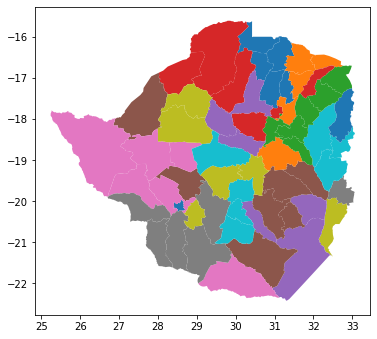

In [9]:
from pathlib import Path
data_path = Path('./dataset/zwe2016phia.geojson')

df = gpd.read_file(data_path)

_, ax = plt.subplots(figsize=(6, 6))
df.plot(column='area_id', ax=ax)
plt.show()

In [10]:
df.columns

Index(['indicator', 'survey_id', 'survey_mid_calendar_quarter', 'area_id',
       'area_name', 'res_type', 'sex', 'age_group', 'n_clusters',
       'n_observations', 'n_eff_kish', 'estimate', 'std_error', 'ci_lower',
       'ci_upper', 'y', 'n_obs', 'iso3', 'area_level', 'parent_area_id',
       'spectrum_region_code', 'area_sort_order', 'center_x', 'center_y',
       'area_level_label', 'display', 'spectrum_level', 'epp_level',
       'naomi_level', 'pepfar_psnu_level', 'geometry'],
      dtype='object')

In [19]:
df = df[[
    'area_id',
    'geometry',
    'y',
    'n_obs',
    'estimate',
]]

df['y'] = round(df.y).astype(int)
df['n_obs'] = round(df.n_obs).astype(int)

print(f'Number of NaNs in n_obs = {np.sum(np.isnan(df.n_obs))}')

Number of NaNs in n_obs = 0


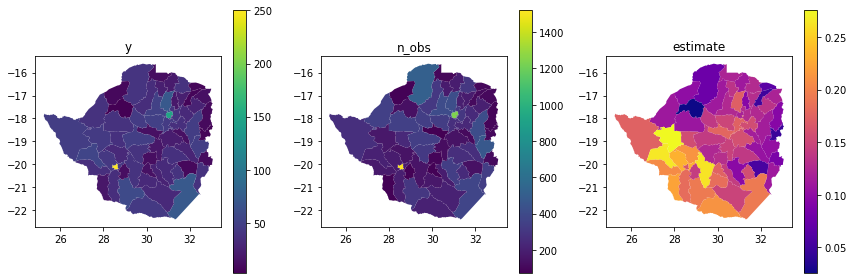

In [25]:
_, ax = plt.subplots(1, 3, figsize=(12, 4))
df.plot(column='y', ax=ax[0], legend=True)
df.plot(column='n_obs', ax=ax[1], legend=True)
df.plot(column='estimate', ax=ax[2], cmap='plasma', legend=True)

ax[0].set_title('y')
ax[1].set_title('n_obs')
ax[2].set_title('estimate')

plt.tight_layout()
plt.show()

In [46]:
polygons = df['geometry'].copy()
A = polygons.geometry.apply(lambda g: polygons.intersects(g))
A = np.array(A * 1)
A = A - np.eye(A.shape[0])

assert np.all(A.sum(axis=0) == A.sum(axis=1))
d = A.sum(axis=0)

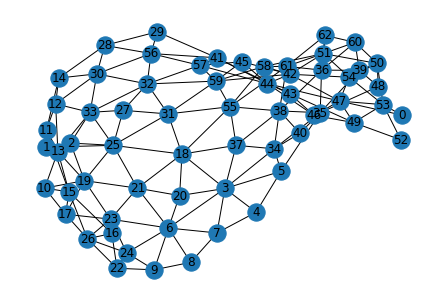

In [47]:
import networkx as nx
g = nx.from_numpy_matrix(A)
nx.draw(g, with_labels=True)

In [51]:
from dataclasses import dataclass
from typing import Dict, Optional

Params = Dict[str, Dict[str, jnp.ndarray]]

@dataclass
class CARArgs:
  adj_matrix: np.ndarray = A
  degree_vector: jnp.ndarray = d
  n_obs_vector: jnp.ndarray = jnp.array(df.n_obs)
  num_regions: int = len(polygons)
  
  decoder_params: Optional[Params] = None
  scaler: Optional[callable] = None
  
CAR_ARGS = CARArgs()

In [53]:
def car_predictive_model(args: CARArgs, y=None) -> None:
  A = jnp.array(args.adj_matrix)
  D = jnp.diag(args.degree_vector)
  n_obs = args.n_obs_vector

  # Fixed effects
  alpha = numpyro.sample('alpha', dist.Uniform(low=0.01, high=0.999))

  Q_std = (D - alpha*A)
  numpyro.sample('car_std', dist.MultivariateNormal(loc=jnp.zeros(args.num_regions), precision_matrix=Q_std))

In [57]:
def prevalence_car_predictive_model(args: CARArgs, y=None) -> None:
  A = jnp.array(args.adj_matrix)
  D = jnp.diag(args.degree_vector)
  n_obs = args.n_obs_vector

  # Fixed effects
  b0 = numpyro.sample('b0', dist.Normal(0, 1))
  tau = numpyro.sample('tau', dist.Gamma(6, 4)) 
  alpha = numpyro.sample('alpha', dist.Uniform(low=0., high=1.))

  Q_std = (D - alpha*A)
  car_std = numpyro.sample('car_std', dist.MultivariateNormal(loc=jnp.zeros(args.num_regions), precision_matrix=Q_std))
  sigma = numpyro.deterministic('sigma', 1./jnp.sqrt(tau))
  car = numpyro.deterministic('car', sigma * car_std)

  numpyro.deterministic('CAR 1', car[0])

  lp = b0 + car
  numpyro.deterministic("theta", jax.nn.sigmoid(lp))
      
  numpyro.sample("obs", dist.BinomialLogits(total_count = n_obs, logits=lp), obs=y)

In [58]:
RNG_KEY, mcmc_rng = jax.random.split(RNG_KEY)

# Inference
start = time.time()
kernel = NUTS(prevalence_car_predictive_model)
mcmc_car = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc_car.run(mcmc_rng, CAR_ARGS, y=jnp.array(df.y))
t_elapsed = time.time() - start

prevalence_car_samples = mcmc_car.get_samples()

sample: 100%|██████████| 3000/3000 [02:28<00:00, 20.22it/s, 31 steps of size 1.27e-01. acc. prob=0.94] 


In [59]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")
ss = numpyro.diagnostics.summary(mcmc_car.get_samples(group_by_chain=True))
r = np.mean(ss['car']['n_eff'])
print("Average ESS for all CAR effects : " + str(round(r)))


MCMC elapsed time: 152 s
Average ESS for all CAR effects : 47


Text(0.5, 1.0, 'Estimated prevalence (CAR model)')

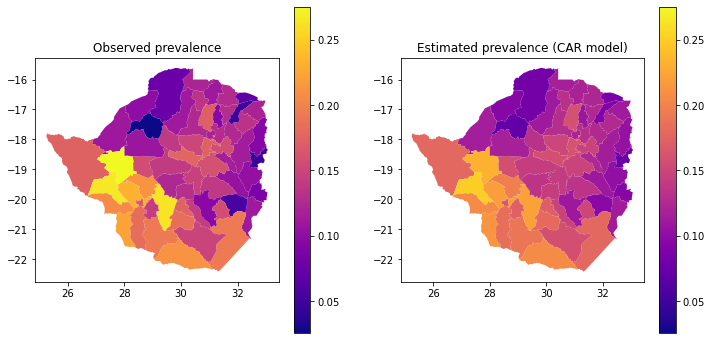

In [60]:
RNG_KEY, predictive_rng = jax.random.split(RNG_KEY)

# Posterior predictive.
prev_posterior_predictive = Predictive(
    prevalence_car_predictive_model, prevalence_car_samples)(predictive_rng, CAR_ARGS)

theta_samps_car = prev_posterior_predictive['theta']
theta_mean_car = theta_samps_car.mean(axis=0)
bci_car_25 = np.quantile(theta_samps_car, 0.25, axis=0)
bci_car_75 = np.quantile(theta_samps_car, 0.75, axis=0)

df['theta_car'] = theta_mean_car

theta_observed = df['estimate']
theta_estimated_car = df['theta_car']

_max = np.max([theta_observed, theta_estimated_car])
_min = np.min([theta_observed, theta_estimated_car])

fig, ax = plt.subplots(1, 2, figsize=(12,6))
df.plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
df.plot(column="theta_car", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)
ax[0].set_title( 'Observed prevalence')
ax[1].set_title( 'Estimated prevalence (CAR model)')

mse_car = 0.00023534589577094546


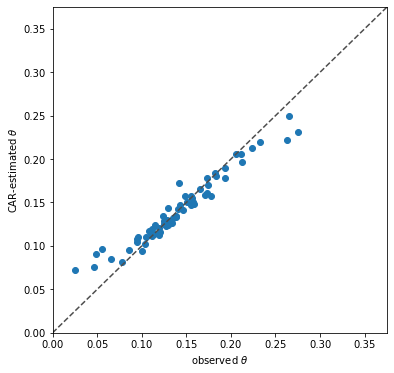

In [61]:
import plotting

plotting.plot_compare_estimates(
    data_x=theta_observed, data_y=theta_estimated_car,
    x_label=r'observed $\theta$', y_label=r'CAR-estimated $\theta$',
    figsize=(6, 6),
)

mse_car = np.mean((theta_observed -  theta_estimated_car)**2)
print(f'mse_car = {mse_car}')

# Creating dataset

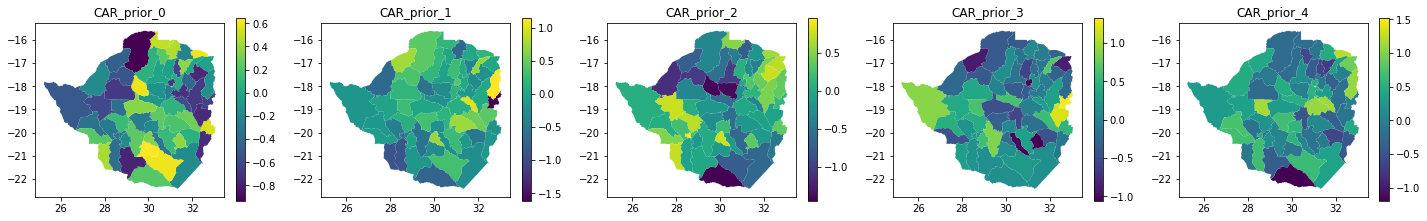

In [123]:
# CAR: prior predictive
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)

num_to_plot = 5
car_preds = Predictive(car_predictive_model, num_samples=num_to_plot)(rng_pred, CAR_ARGS)
car_draws = car_preds['car_std']

_, axes = plt.subplots(1, num_to_plot, figsize=(20, 3))

df_plot_samples = df.copy()
for i in range(5):
    title = f'CAR_prior_{i}'
    df_plot_samples[title] = car_draws[i]
    df_plot_samples.plot(column=title, ax=axes[i], legend=True)
    axes[i].set_title(title)
    
plt.tight_layout()
plt.show()

In [105]:
import dataset

def generate_car_batch(
        rng: jax.random.PRNGKey, 
        batch_size: int = 1,
        model_args: CARArgs = CAR_ARGS) -> jnp.ndarray:
    car_preds = Predictive(
        car_predictive_model, num_samples=batch_size)(rng, model_args)
    car_draws = car_preds['car_std']  # (batch_size, num_regions)
    return car_draws

# VGAE-CAR

In [134]:
import loss
from typing import Callable, NamedTuple

LossFun = Callable[[jax.numpy.ndarray, jax.numpy.ndarray], jnp.float32]

class Args(NamedTuple):
  loss_fn: LossFun = loss.compute_mse_loss
  num_nodes: int = A.shape[0]  
  batch_size: int = 1
  scale: int = 1.0
  
  act_fn = jax.nn.leaky_relu
  hidden_dim: int = 50
  latent_dim: int = 10
  output_dim: int = 1
  
  learning_rate: float = 1e-4
  epochs: int = 100_000
  
  eval_frequency: int = 1000
  
ARGS = Args()
print(ARGS)

Args(loss_fn=<function compute_mse_loss at 0x11671e670>, num_nodes=63, batch_size=1, scale=1.0, hidden_dim=50, latent_dim=10, output_dim=1, learning_rate=0.0001, epochs=1000, eval_frequency=100)


In [154]:
from pathlib import Path
train_path = Path.cwd() / 'dataset/zimbabwe_car_train_data.npy'
val_path = Path.cwd() / 'dataset/zimbabwe_car_val_data.npy'

OVERRIDE_SAVE = True

RNG_KEY, train_rng, val_rng = jax.random.split(RNG_KEY, 3)
if (train_path.exists() and val_path.exists()) and not OVERRIDE_SAVE:
    train_data = jnp.array(np.load(train_path))
    val_data = jnp.array(np.load(val_path))
else:
    train_data = generate_car_batch(train_rng, batch_size=200_000)
    val_data = generate_car_batch(val_rng, batch_size=200_000)
    np.save(train_path, np.asarray(train_data))
    np.save(val_path, np.asarray(val_data))

In [ ]:
from preprocess import LinearScaler, NoScaler

scaler = LinearScaler(scale=ARGS.scale)
scaled_train_data = scaler.fit_transform(train_data)
scaled_val_data = scaler.transform(val_data)

BASE_GRAPH = dataset.create_grid_graph(CAR_ARGS.adj_matrix)
scaled_graph_train_data = [
    BASE_GRAPH._replace(nodes=draw.reshape(-1, 1)) 
        for draw in scaled_train_data
]
scaled_graph_val_data = [
    BASE_GRAPH._replace(nodes=draw.reshape(-1, 1)) 
        for draw in scaled_val_data
]

CAR_ARGS.scaler = scaler

In [ ]:
from typing import Tuple

def encoder(
        graph: jraph.GraphsTuple,
        hidden_dim: int,
        latent_dim: int,
        act_fn: Callable = jax.nn.leaky_relu
    ) -> Tuple[jraph.GraphsTuple, jraph.GraphsTuple]:

    # Graph layer
    gn = jraph.GraphConvolution(
        update_node_fn=hk.Sequential([hk.Linear(hidden_dim), act_fn]),
    )
    graph = gn(graph)
    
    # No activation
    gn_mean = jraph.GraphConvolution(update_node_fn=hk.Linear(latent_dim))
    gn_log_std = jraph.GraphConvolution(update_node_fn=hk.Linear(latent_dim))
    
    mean_graph, log_std_graph = gn_mean(graph), gn_log_std(graph)
    return mean_graph, log_std_graph


def decoder(
        graph: jraph.GraphsTuple,
        hidden_dim: int,
        output_dim: int,
        act_fn: Callable = jax.nn.leaky_relu) -> jraph.GraphsTuple:
    
    gn = jraph.GraphConvolution(
        update_node_fn=hk.Sequential([
            hk.Linear(hidden_dim, name='decoder_hidden'), act_fn,
        ]),
    )
    graph = gn(graph)
    
    # No activation
    gn = jraph.GraphConvolution(
        update_node_fn=hk.Linear(output_dim, name='decoder_output'))
    graph = gn(graph)

    return graph


class VGAE(hk.Module):
    """VGAE network definition."""

    def __init__(
        self,
        hidden_dim,
        latent_dim: int,
        output_dim: int,
    ):
        super().__init__()
        self._hidden_dim = hidden_dim
        self._latent_dim = latent_dim
        self._output_dim = output_dim

    def __call__(self, graph: jraph.GraphsTuple) -> VGAEOutput:
        mean_graph, log_std_graph = encoder(
            graph,
            self._hidden_dim,
            self._latent_dim,
        )
        mean, log_std = mean_graph.nodes, log_std_graph.nodes
        std = jnp.exp(log_std)
        z = mean + std * jax.random.normal(hk.next_rng_key(), mean.shape)
        z_graph = mean_graph._replace(nodes=z)
        output = decoder(
            z_graph,
            self._hidden_dim,
            self._output_dim,
        )

        return VGAEOutput(mean, log_std, output)

In [ ]:
# Initialize network and optimizer.
net = hk.transform(
  lambda x: VGAE(hidden_dim=ARGS.hidden_dim,
                 latent_dim=ARGS.latent_dim, 
                 output_dim=ARGS.output_dim)(x))

optimizer = optax.adam(ARGS.learning_rate)

In [ ]:
from model import VGAEOutput

@jax.jit
def loss_fn(
    params: hk.Params, 
    rng_key: jnp.ndarray,
    graph: jraph.GraphsTuple,
) -> jnp.ndarray:
  """Computes VGAE loss."""
  log_likelihood_loss_fn = ARGS.loss_fn
  
  outputs: VGAEOutput = net.apply(params, rng_key, graph)
  log_likelihood = -log_likelihood_loss_fn(outputs.output.nodes, graph.nodes)
  kld = jnp.mean(loss.compute_kl_gaussian(outputs.mean, outputs.log_std), axis=-1)
  elbo = log_likelihood - kld
  
  return -elbo
  
@jax.jit
def update(
    params: hk.Params,
    rng_key: jnp.ndarray,
    opt_state: optax.OptState,
    graph: jraph.GraphsTuple,
):
  """Updates the parameters of the network."""
  grads = jax.grad(loss_fn)(params, rng_key, graph)
  updates, new_opt_state = optimizer.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state

In [ ]:
# Initialize net with an arbitrary graph
RNG_KEY, params_rng = jax.random.split(RNG_KEY)

init_graph = scaled_graph_train_data[0]
params = net.init(params_rng, init_graph)
opt_state = optimizer.init(params)

In [ ]:
RNG_KEY, train_rng = jax.random.split(RNG_KEY)

train_losses = []
val_losses = []

training_start_time = time.time()
print('using: ', ARGS.loss_fn)
for epoch in range(ARGS.epochs):
  update_rng = jax.random.fold_in(train_rng, epoch)

  train_graph_batch = scaled_graph_train_data[epoch]
  params, opt_state = update(params, update_rng, opt_state, train_graph_batch)
    
  if epoch % ARGS.eval_frequency == 0 or epoch == (ARGS.epochs - 1):
    evaluate_rng = jax.random.fold_in(update_rng, epoch)
    train_loss_rng, eval_loss_rng = jax.random.split(evaluate_rng)
    
    train_loss = loss_fn(params, train_loss_rng, train_graph_batch)
    
    val_graph_batch = scaled_graph_val_data[epoch]
    val_loss = loss_fn(params, eval_loss_rng, val_graph_batch)
    
    print(f'{time.strftime("%H:%M:%S", time.localtime())} STEP: {epoch}; '
                f'Train loss: {train_loss:.3f}; Validation loss: {val_loss:.3f}')
      
    train_losses.append(train_loss)
    val_losses.append(val_loss)

training_end_time = time.time() - training_start_time
print(f'Training took: ({training_end_time:.3f} secs; equivalently {training_end_time/60:.3f} mins)')

using:  <function compute_mse_loss at 0x11671e670>
23:17:08 STEP: 0; Train loss: 0.826; Validation loss: 0.962
23:17:08 STEP: 100; Train loss: 0.508; Validation loss: 0.377
23:17:08 STEP: 200; Train loss: 0.287; Validation loss: 0.401
23:17:08 STEP: 300; Train loss: 0.260; Validation loss: 0.315
23:17:08 STEP: 400; Train loss: 0.326; Validation loss: 0.261
23:17:08 STEP: 500; Train loss: 0.209; Validation loss: 0.280
23:17:08 STEP: 600; Train loss: 0.175; Validation loss: 0.295
23:17:08 STEP: 700; Train loss: 0.367; Validation loss: 0.175
23:17:08 STEP: 800; Train loss: 0.269; Validation loss: 0.224
23:17:09 STEP: 900; Train loss: 0.332; Validation loss: 0.805
23:17:09 STEP: 999; Train loss: 0.285; Validation loss: 0.154
Training took: (2.059 secs; equivalently 0.034 mins)


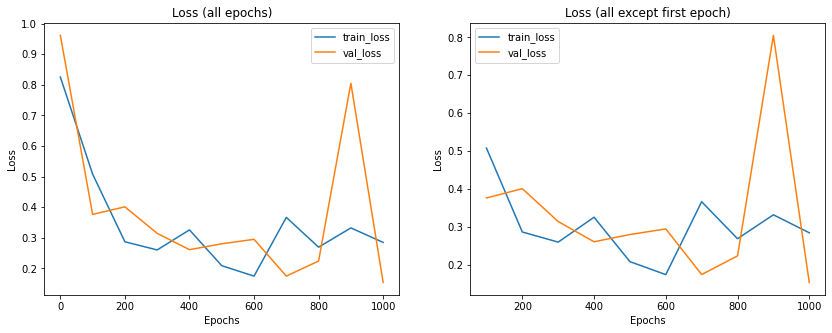

In [ ]:
from matplotlib.ticker import MaxNLocator

_, axes = plt.subplots(1, 2, figsize=(14, 5))

# for i in range(2): axes[i].xaxis.set_major_locator(MaxNLocator(integer=True))

xs = np.arange(len(train_losses))*ARGS.eval_frequency
axes[0].plot(xs, train_losses, label='train_loss')
axes[0].plot(xs, val_losses, label='val_loss')
axes[1].plot(xs[1:], train_losses[1:], label='train_loss')
axes[1].plot(xs[1:], val_losses[1:], label='val_loss')
axes[0].set_title('Loss (all epochs)')
axes[1].set_title('Loss (all except first epoch)')

for i in range(2): 
    axes[i].set_ylabel('Loss')
    axes[i].set_xlabel('Epochs')
    axes[i].legend()
plt.show()

In [ ]:
# CAR: prior predictive
RNG_KEY, rng_pred = jax.random.split(RNG_KEY)

num_to_plot = 5
car_preds = Predictive(car_predictive_model, num_samples=num_to_plot)(rng_pred, CAR_ARGS)
car_draws = car_preds['car_std']

_, axes = plt.subplots(1, num_to_plot, figsize=(20, 3))

df_plot_samples = df.copy()
for i in range(5):
    title = f'CAR_prior_{i}'
    df_plot_samples[title] = car_draws[i]
    df_plot_samples.plot(column=title, ax=axes[i], legend=True)
    axes[i].set_title(title)
    
plt.tight_layout()
plt.show()

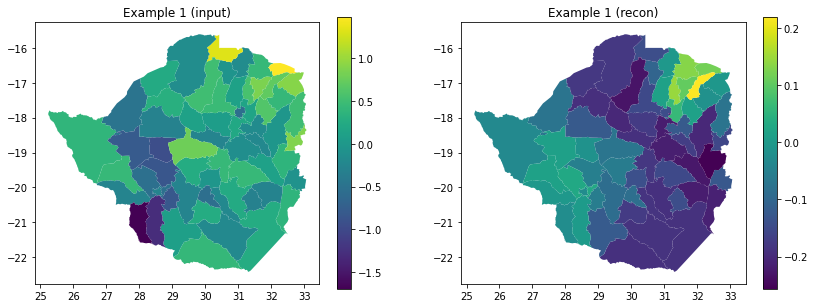

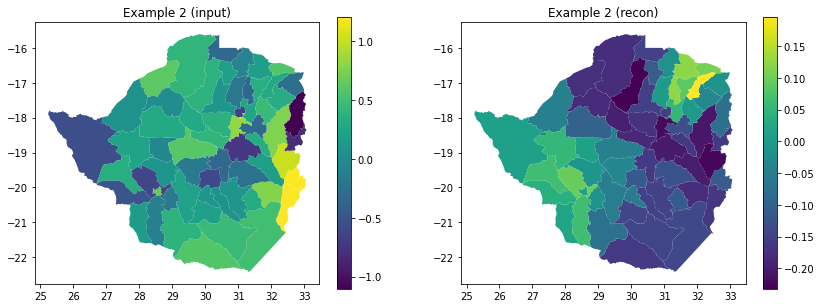

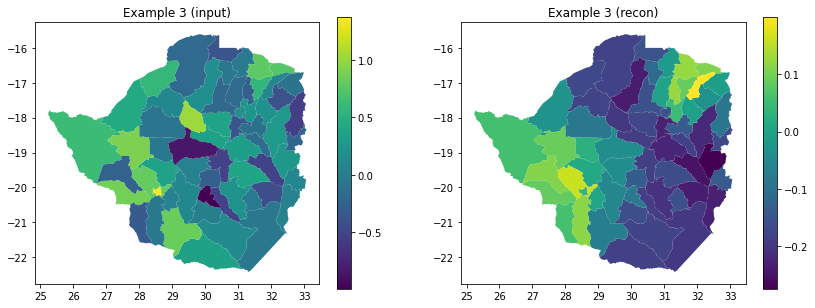

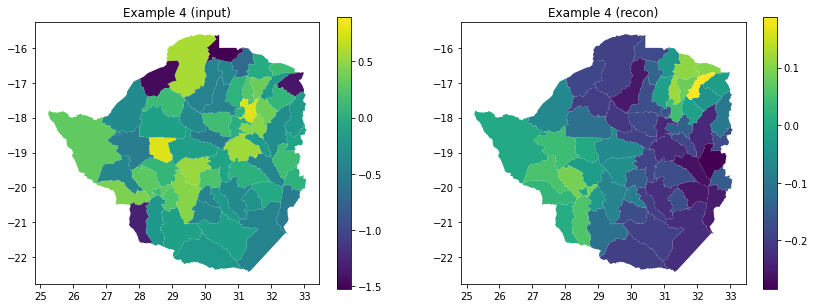

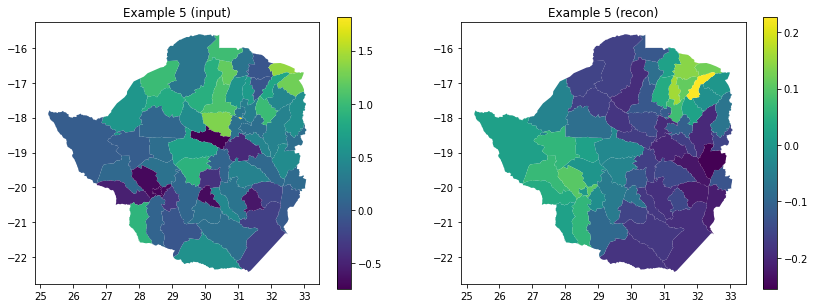

In [ ]:
RNG_KEY, rng_recon = jax.random.split(RNG_KEY)

for i in range(5):
    original_data = val_data[i]
    scaled_data_graph = scaled_graph_val_data[i]
    outputs = net.apply(params, RNG_KEY, scaled_data_graph)

    # Unscaling
    recon_data = scaler.inverse_transform(jnp.ravel(outputs.output.nodes))

    original_image = jnp.ravel(original_data)
    recon_image = jnp.ravel(recon_data)

    # Plotting
    _, axes = plt.subplots(1, 2, figsize=(14, 5))
    t = df.copy()
    title_original = f'original_{i}'
    title_recon = f'recon_{i}'
    t[title_original] = original_image
    t[title_recon] = recon_image
    t.plot(column=title_original, ax=axes[0], legend=True)
    t.plot(column=title_recon, ax=axes[1], legend=True)
    axes[0].set_title(f'Example {i+1} (input)')
    axes[1].set_title(f'Example {i+1} (recon)')

# plt.tight_layout()
plt.show()

In [ ]:
print(ARGS)

Args(loss_fn=<function compute_mse_loss at 0x11671e670>, num_nodes=63, batch_size=1, scale=1.0, hidden_dim=50, latent_dim=10, output_dim=1, learning_rate=0.0001, epochs=1000, eval_frequency=100)
